### Imports

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

### Untarring and Saving to Local Directory

In [32]:
fullPath = os.path.abspath("./" + "lfw.tgz")
data_lfw = keras.utils.get_file("lfw.tgz", 'file://'+ fullPath, untar=True, cache_dir=".")
dataset_dir = os.path.join(os.path.dirname(data_lfw), "lfw")

### Creating Dataset from Images

In [33]:
data_dir_1 = "./datasets/face_lfw"
# data_dir_2 = "./datasets/nonface"
image_size = 256
batch_size = 32
color_bytes = 3

# train_data, test_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=20, image_size=image_size, batch_size=batch_size)


In [34]:
# Getting number of files in directory

count = 0
for root_dir, cur_dir, files in os.walk(data_dir_1):
    count += len(files)
print('file count:', count)


file count: 19150


In [35]:
# Creating Dataset from Face Images

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

Found 19146 files belonging to 2 classes.
Using 15317 files for training.
Found 19146 files belonging to 2 classes.
Using 3829 files for validation.


### Displaying Sample Data

In [36]:
class_names = train_ds.class_names
print(class_names)

['faces', 'nonfaces']


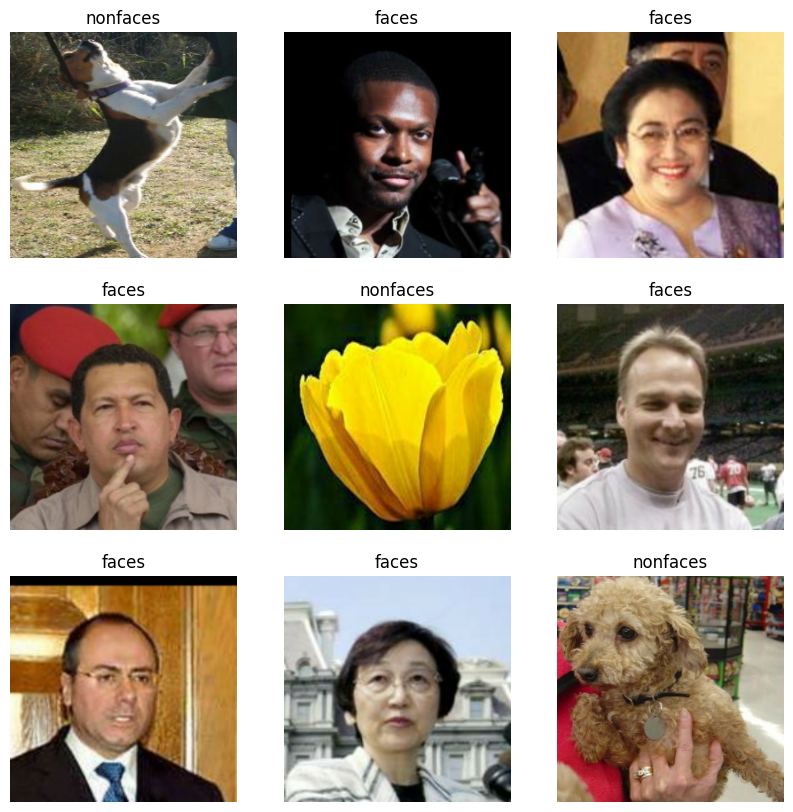

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

In [39]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

In [41]:
#result = self.step(batch, self.forward_only)

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


2022-11-28 17:42:39.330939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 229 of 1000
2022-11-28 17:42:49.326472: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 450 of 1000
2022-11-28 17:42:50.123087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


479/479 [==============================] - 343s 668ms/step - loss: 0.1089 - accuracy: 0.9623 - val_loss: 0.0168 - val_accuracy: 0.9945
Epoch 2/5
479/479 [==============================] - 324s 674ms/step - loss: 0.0141 - accuracy: 0.9950 - val_loss: 0.0073 - val_accuracy: 0.9979
Epoch 3/5
479/479 [==============================] - 336s 700ms/step - loss: 0.0168 - accuracy: 0.9949 - val_loss: 0.0127 - val_accuracy: 0.9958
Epoch 4/5
479/479 [==============================] - 315s 657ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0074 - val_accuracy: 0.9982
Epoch 5/5
479/479 [==============================] - 315s 657ms/step - loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0142 - val_accuracy: 0.9948


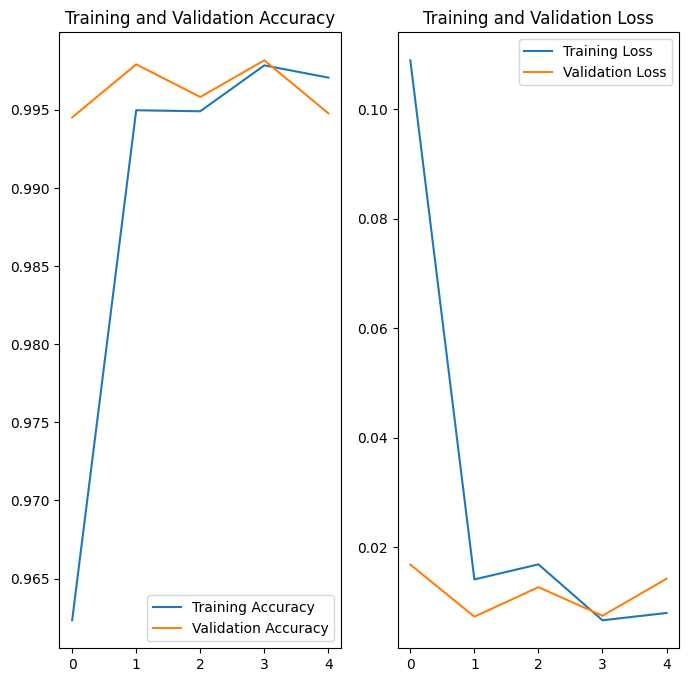

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

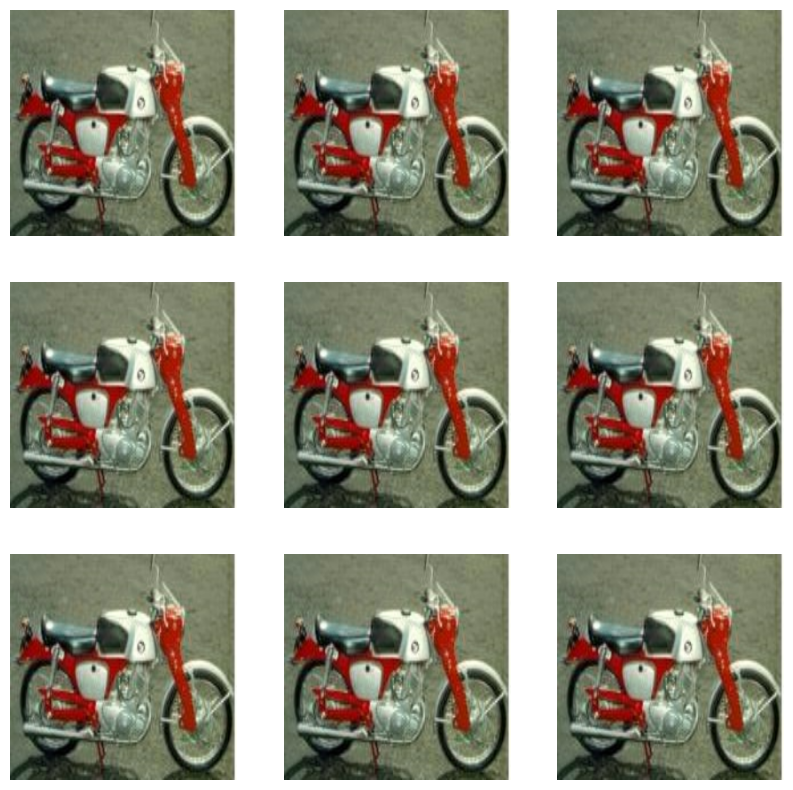

In [44]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [45]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [46]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                 

In [51]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
479/479 [==============================] - 419s 874ms/step - loss: 0.0522 - accuracy: 0.9810 - val_loss: 0.0176 - val_accuracy: 0.9953
Epoch 2/10
479/479 [==============================] - 427s 892ms/step - loss: 0.0527 - accuracy: 0.9830 - val_loss: 0.0313 - val_accuracy: 0.9914
Epoch 3/10
479/479 [==============================] - 416s 868ms/step - loss: 0.0294 - accuracy: 0.9890 - val_loss: 0.0158 - val_accuracy: 0.9961
Epoch 4/10
479/479 [==============================] - 414s 865ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0175 - val_accuracy: 0.9953
Epoch 5/10
479/479 [==============================] - 421s 880ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.0083 - val_accuracy: 0.9979
Epoch 6/10
479/479 [==============================] - 481s 1s/step - loss: 0.0198 - accuracy: 0.9930 - val_loss: 0.0149 - val_accuracy: 0.9943
Epoch 7/10
479/479 [==============================] - 460s 960ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 0.0088 - va

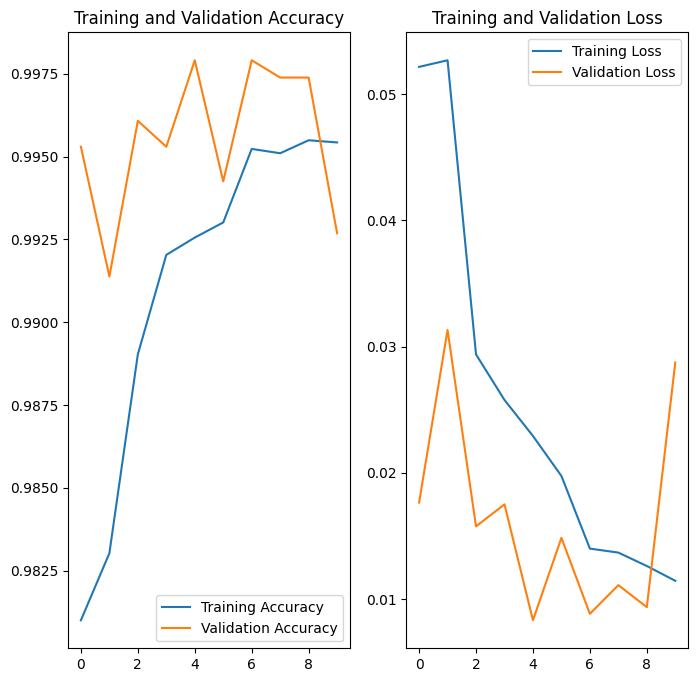

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
img_url = "https://img.freepik.com/free-photo/portrait-white-man-isolated_53876-40306.jpg"
img_path = tf.keras.utils.get_file('test_img_3', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_size, image_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

img_url = "https://images.unsplash.com/photo-1484591974057-265bb767ef71?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxleHBsb3JlLWZlZWR8MXx8fGVufDB8fHx8&w=1000&q=80"
img_path = tf.keras.utils.get_file('test_img_4', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_size, image_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 71ms/step
[[ 6.626192  -2.8053155]]
This image most likely belongs to faces with a 99.99 percent confidence.
1/1 [==============================] - 0s 49ms/step
[[-8.730935 11.156904]]
This image most likely belongs to nonfaces with a 100.00 percent confidence.
